In [1]:
from config import args
from pytorch_lightning import Trainer, loggers
from models import get_pl_model
from augmentations import get_transforms
from datasets import get_train_val_dataloaders
import warnings 
warnings.filterwarnings(action= 'ignore')

# Get augmentation

In [2]:
# transform_train=get_transforms('cf')
transform_train=get_transforms('cfc')
transform_val=get_transforms('center_c')

# Get data loaders

In [3]:
train_dataloader, val_dataloader = get_train_val_dataloaders(transform_train=transform_train, transform_val=transform_val, include_massachusetts=False)

# Get model

In [4]:
# model = get_pl_model('unet')
model = get_pl_model('edgemap_fused_unet')
# model = get_pl_model('fpn')
# model = get_pl_model('deeplabv3plus')

# Tensorboard

In [5]:
%load_ext tensorboard
%tensorboard --logdir logs

# Train model

In [6]:
model=model.train()
args.gpus = None # Remove this line if you actually have gpus

tb_logger = loggers.TensorBoardLogger(save_dir="logs/")
trainer = Trainer(gpus=args.gpus,
                  max_epochs=args.epochs, 
                  logger=tb_logger,
                  # accelerator=args.accelerator,
                  resume_from_checkpoint=args.checkpoint_path,
                  log_every_n_steps=10
)
trainer.fit(model, train_dataloader, val_dataloader)

 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | EdgemapFusedModel | 24.5 M
--------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.823    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [7]:
# model.model.model.decoder.blocks[1]

In [8]:
pred_mask_middle=model.model.model(torch.Tensor(img[None,:])).detach().argmin(dim=1).numpy()
pred_mask=model.predict(torch.Tensor(img[None,:])).detach().numpy()

NameError: name 'torch' is not defined

In [ ]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,2)
_ = axarr[0].imshow(pred_mask_middle.transpose(1,2,0))
_ = axarr[1].imshow(pred_mask.transpose(1,2,0))

In [ ]:
pred_mask_middle.shape

In [ ]:
pred_mask.shape

# Visualize

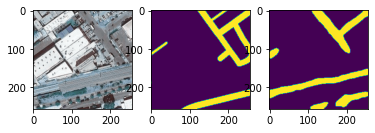

In [15]:
import matplotlib.pyplot as plt
import torch

img, mask = val_dataloader.dataset[9]
# fused = model.model.get_fused_input(torch.Tensor(img[None,:]))
pred_mask=model.predict(torch.Tensor(img[None,:])).detach().numpy()
f, axarr = plt.subplots(1,3)
_ = axarr[0].imshow(img.transpose(1,2,0))
_ = axarr[1].imshow(mask.transpose(1,2,0))
_ = axarr[2].imshow(pred_mask.transpose(1,2,0))
# _ = axarr[3].imshow(fused[0,3:,...].numpy().transpose(1,2,0))

In [ ]:
from segmentation_models_pytorch.encoders import get_encoder
from pytorch_hed.run import estimate

In [ ]:
resnet = get_encoder(
    'resnet34',
    in_channels=1,
    # depth=encoder_depth,
    weights='imagenet',
)

In [ ]:
edgemap = estimate(torch.Tensor(img[None,:]))

In [ ]:
edgemap.shape

In [ ]:
edgemap = model.model.edgemap_layers(edgemap)

In [ ]:
# model.model.model(img)
pred_middle_mask=model.model.model(torch.Tensor(img[None,:])).detach()

In [ ]:
out=pred_middle_mask+edgemap

In [ ]:
pred_middle_mask.shape

In [ ]:
# pred_middle_mask

pred_middle_mask = pred_middle_mask.argmax(dim=1)
plt.imshow((-pred_middle_mask.detach().numpy()+pred_mask).transpose(1,2,0))

In [ ]:
out = out.max(dim=1).values
plt.imshow(out.detach().numpy().transpose(1,2,0))

In [ ]:
pred_middle_mask.shape

In [ ]:
edgemap

In [ ]:
edgemap = edgemap.argmax(dim=1)

In [ ]:
edgemap=edgemap.detach().numpy()[0][None,:].transpose(1,2,0)

In [ ]:
edgemap=edgemap.detach().numpy()[0].transpose(1,2,0)

In [ ]:
plt.imshow(edgemap)

In [ ]:
plt.imshow(edgemap)

In [ ]:
resnet_out = resnet.forward(edgemap)

In [ ]:
edgemap

In [ ]:
resnet_out[1].shape

In [ ]:
edgemap_out=resnet_out[2][0][:1].detach().numpy().transpose(1,2,0)

In [ ]:
edgemap_out.shape

In [ ]:
plt.imshow(edgemap_out)

In [ ]:
edgemap_out.mean(),edgemap.mean()